In [15]:
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import pyplot as plt
import seaborn as sns 
sns.set_style("white")

from xgboost import XGBClassifier

import logging
log = logging.getLogger('logs/link_prediction_xgboost.log')

In [2]:
# 'user_groups_freebase_weighted_average_diversity', 'user_groups_mainstreaminess_global', 'user_groups_novelty_artist_avg_6months'
dataset_id = 0
listening_characteristics_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_id) + '/links_df_listening_characteristics_features.csv', index_col=0)
listening_characteristics_features_df = listening_characteristics_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
listening_characteristics_features_df = listening_characteristics_features_df[[
    'user1_freebase_weighted_average_diversity',
    'user2_freebase_weighted_average_diversity',
    'relative_change_freebase_weighted_average_diversity',
    'user1_user_groups_freebase_weighted_average_diversity_high',
    'user1_user_groups_freebase_weighted_average_diversity_low',
    'user1_user_groups_freebase_weighted_average_diversity_medium',
    'user2_user_groups_freebase_weighted_average_diversity_high',
    'user2_user_groups_freebase_weighted_average_diversity_low',
    'user2_user_groups_freebase_weighted_average_diversity_medium',
    'same_user_groups_freebase_weighted_average_diversity',
    'user1_mainstreaminess_global',
    'user2_mainstreaminess_global',
    'relative_change_mainstreaminess_global',
    'user1_user_groups_mainstreaminess_global_high',
    'user1_user_groups_mainstreaminess_global_low',
    'user1_user_groups_mainstreaminess_global_medium',
    'user2_user_groups_mainstreaminess_global_high',
    'user2_user_groups_mainstreaminess_global_low',
    'user2_user_groups_mainstreaminess_global_medium',
    'same_user_groups_mainstreaminess_global',
    'user1_novelty_artist_avg_6months',
    'user2_novelty_artist_avg_6months',
    'relative_change_novelty_artist_avg_6months',
    'user1_user_groups_novelty_artist_avg_6months_high',
    'user1_user_groups_novelty_artist_avg_6months_low',
    'user1_user_groups_novelty_artist_avg_6months_medium',
    'user2_user_groups_novelty_artist_avg_6months_high',
    'user2_user_groups_novelty_artist_avg_6months_low',
    'user2_user_groups_novelty_artist_avg_6months_medium',
    'same_user_groups_novelty_artist_avg_6months',
    'label'
]]
X_train, X_test, y_train, y_test = train_test_split(listening_characteristics_features_df.drop(columns=['label']), listening_characteristics_features_df['label'], test_size=0.2, random_state=0)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
report = classification_report(y_test, predictions)
prfs_macro = precision_recall_fscore_support(y_test, predictions, average='macro')
prfs_micro = precision_recall_fscore_support(y_test, predictions, average='micro')
prfs_weighted = precision_recall_fscore_support(y_test, predictions, average='weighted')
print(prfs_weighted)
feature_importances = sorted(list(zip(xgb.feature_importances_, list(X_train.columns))),  key=lambda x: x[0], reverse=True)

[08:04:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7228755847081089, 0.7224965185466514, 0.7223489371573381, None)


In [3]:
report

'              precision    recall  f1-score   support\n\n           0       0.71      0.74      0.73     15846\n           1       0.73      0.70      0.72     15750\n\n    accuracy                           0.72     31596\n   macro avg       0.72      0.72      0.72     31596\nweighted avg       0.72      0.72      0.72     31596\n'

In [4]:
feature_importances

[(0.39396644, 'same_user_groups_freebase_weighted_average_diversity'),
 (0.06568945, 'user1_novelty_artist_avg_6months'),
 (0.05845456, 'user1_mainstreaminess_global'),
 (0.057491887, 'user1_freebase_weighted_average_diversity'),
 (0.047264636, 'user2_novelty_artist_avg_6months'),
 (0.044477414, 'user1_user_groups_freebase_weighted_average_diversity_medium'),
 (0.04440602, 'same_user_groups_novelty_artist_avg_6months'),
 (0.041110113, 'user2_mainstreaminess_global'),
 (0.040446315, 'user1_user_groups_mainstreaminess_global_medium'),
 (0.040399186, 'user2_freebase_weighted_average_diversity'),
 (0.033925865, 'user2_user_groups_freebase_weighted_average_diversity_medium'),
 (0.03240285, 'user1_user_groups_novelty_artist_avg_6months_medium'),
 (0.02242296, 'relative_change_mainstreaminess_global'),
 (0.021472245, 'relative_change_freebase_weighted_average_diversity'),
 (0.01630673, 'user2_user_groups_novelty_artist_avg_6months_medium'),
 (0.015262806, 'relative_change_novelty_artist_avg_6

In [5]:
mainstreaminess_sum = 0
novelty_sum = 0
diversity_sum = 0
for feature in feature_importances:
    if 'mainstreaminess' in feature[1]:
        mainstreaminess_sum += feature[0]
    if 'novelty' in feature[1]:
        novelty_sum += feature[0]
    if 'diversity' in feature[1]:
        diversity_sum += feature[0]

In [7]:
print('Mainstreaminess feature importance sum: ', mainstreaminess_sum)
print('Novelty feature importance sum: ', novelty_sum)
print('Diversity feature importance sum: ', diversity_sum)

Mainstreaminess feature importance sum:  0.18693452142179012
Novelty feature importance sum:  0.22133249323815107
Diversity feature importance sum:  0.5917330347001553


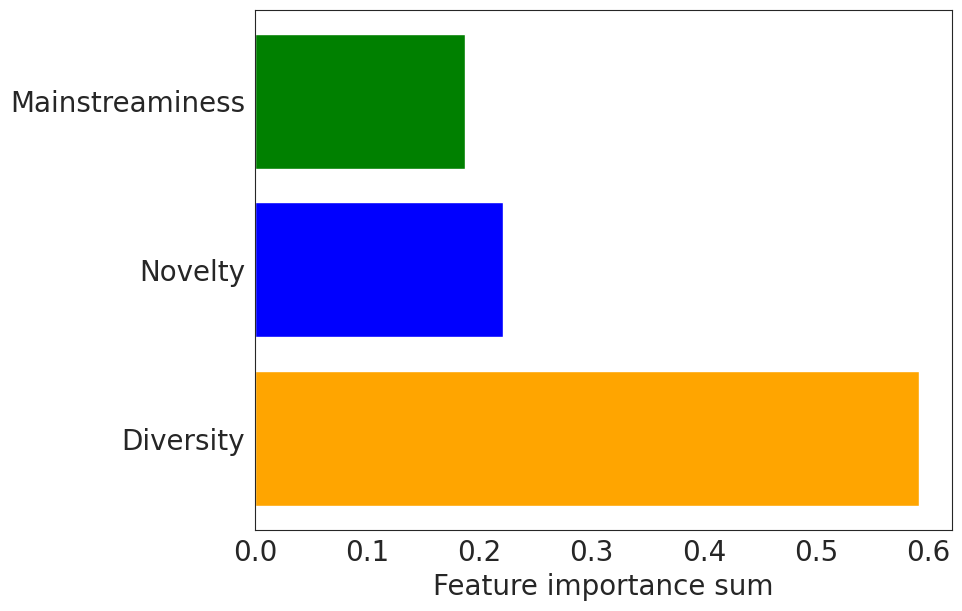

In [23]:
# plt.rcdefaults()
sns.set_style("white")
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize' : (9,6.75)})
fig, ax = plt.subplots()

# Example data
metric = ('Mainstreaminess', 'Novelty', 'Diversity')
y_pos = np.arange(len(metric))
performance = np.array([mainstreaminess_sum, novelty_sum, diversity_sum])

ax.barh(y_pos, performance, align='center', color=['green', 'blue', 'orange'])
ax.set_yticks(y_pos)
ax.set_yticklabels(metric)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature importance sum')

plt.savefig('figures/feature_importance_sums.pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [11]:
3 + 10 * np.random.rand(3)

array([3.74975518, 9.22553564, 8.35570891])